原文代码作者：François Chollet

github：https://github.com/fchollet/deep-learning-with-python-notebooks

中文注释制作：黄海广

github：https://github.com/fengdu78

代码全部测试通过。

配置环境：keras 2.2.1（原文是2.0.8，运行结果一致），tensorflow 1.8，python 3.6，

主机：显卡：一块1080ti；内存：32g（注：绝大部分代码不需要GPU）
![公众号](data/gongzhong.jpg)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.1'

# Neural style transfer
# 神经风格迁移

This notebook contains the code samples found in Chapter 8, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


Besides Deep Dream, another major development in deep learning-driven image modification that happened in the summer of 2015 is neural 
style transfer, introduced by Leon Gatys et al. The neural style transfer algorithm has undergone many refinements and spawned many 
variations since its original introduction, including a viral smartphone app, called Prisma. For simplicity, this section focuses on the 
formulation described in the original paper.

Neural style transfer consists in applying the "style" of a reference image to a target image, while conserving the "content" of the target 
image:

除 DeepDream 之外，深度学习驱动图像修改的另一项重大进展是 神经风格迁移（neural style transfer），它由 Leon Gatys 等人于 2015 年夏天提出。自首次提出以来，神经风格迁移算法已经做了许多改进，并衍生出许多变体，而且还成功转化成许多智能手机图片应用。为了简单起见，本节将重点介绍原始论文中描述的方法。

神经风格迁移是指将参考图像的风格应用于目标图像，同时保留目标图像的内容。


![style transfer](data/style_transfer.png)


What is meant by "style" is essentially textures, colors, and visual patterns in the image, at various spatial scales, while the "content" 
is the higher-level macrostructure of the image. For instance, blue-and-yellow circular brush strokes are considered to be the "style" in 
the above example using Starry Night by Van Gogh, while the buildings in the Tuebingen photograph are considered to be the "content".

The idea of style transfer, tightly related to that of texture generation, has had a long history in the image processing community prior 
to the development of neural style transfer in 2015. However, as it turned out, the deep learning-based implementations of style transfer 
offered results unparalleled by what could be previously achieved with classical computer vision techniques, and triggered an amazing 
renaissance in creative applications of computer vision.

The key notion behind implementing style transfer is same idea that is central to all deep learning algorithms: we define a loss function 
to specify what we want to achieve, and we minimize this loss. We know what we want to achieve: conserve the "content" of the original image, 
while adopting the "style" of the reference image. If we were able to mathematically define content and style, then an appropriate loss 
function to minimize would be the following:

在当前语境下，风格（style）是指图像中不同空间尺度的纹理、颜色和视觉图案，内容（content）是指图像的高级宏观结构。举个例子，在图 8-7 中（用到的参考图像是文森特 • 梵高 的《星夜》），蓝黄色圆形笔划被看作风格，而 Tübingen（图宾根）照片中的建筑则被看作内容。

风格迁移这一想法与纹理生成的想法密切相关，在 2015 年开发出神经风格迁移之前，这一想法就已经在图像处理领域有着悠久的历史。但事实证明，与之前经典的计算机视觉技术实现相比，基于深度学习的风格迁移实现得到的结果是无与伦比的，并且还在计算机视觉的创造性应用中引发了惊人的复兴。

实现风格迁移背后的关键概念与所有深度学习算法的核心思想是一样的：定义一个损失函数来指定想要实现的目标，然后将这个损失最小化。你知道想要实现的目标是什么，就是保存原始图像的内容，同时采用参考图像的风格。如果我们能够在数学上给出内容和风格的定义， 那么就有一个适当的损失函数（如下所示），我们将对其进行最小化。


```
loss = distance(style(reference_image) - style(generated_image)) +
       distance(content(original_image) - content(generated_image))
```


Where `distance` is a norm function such as the L2 norm, `content` is a function that takes an image and computes a representation of its 
"content", and `style` is a function that takes an image and computes a representation of its "style".

Minimizing this loss would cause `style(generated_image)` to be close to `style(reference_image)`, while `content(generated_image)` would 
be close to `content(generated_image)`, thus achieving style transfer as we defined it.

A fundamental observation made by Gatys et al is that deep convolutional neural networks offer precisely a way to mathematically defined 
the `style` and `content` functions. Let's see how.

这里的 distance 是一个范数函数，比如 L2 范 数；content 是一个函数，输入一张图像，并计算出其内容的表示；style 是一个函数，输入一张图像，并计算出其风格的表示。将这个损失最小化，会使得 style(generated_image) 接近于 style(reference_image)、 content(generated_image) 接近于content(generated_image)，从而实现我们定义的风格迁移。

Gatys 等人发现了一个很重要的观察结果，就是深度卷积神经网络能够从数学上定义 style和 content 两个函数。我们来看一下如何定义。


## The content loss


As you already know, activations from earlier layers in a network contain _local_ information about the image, while activations from 
higher layers contain increasingly _global_ and _abstract_ information. Formulated in a different way, the activations of the different 
layers of a convnet provide a decomposition of the contents of an image over different spatial scales. Therefore we expect the "content" of 
an image, which is more global and more abstract, to be captured by the representations of a top layer of a convnet.

A good candidate for a content loss would thus be to consider a pre-trained convnet, and define as our loss the L2 norm between the 
activations of a top layer computed over the target image and the activations of the same layer computed over the generated image. This 
would guarantee that, as seen from the top layer of the convnet, the generated image will "look similar" to the original target image. 
Assuming that what the top layers of a convnet see is really the "content" of their input images, then this does work as a way to preserve 
image content.

## 内容损失

如你所知，网络更靠底部的层激活包含关于图像的局部信息，而更靠近顶部的层则包含更加全局、更加抽象的信息。卷积神经网络不同层的激活用另一种方式提供了图像内容在不同空间尺度上的分解。因此，图像的内容是更加全局和抽象的，我们认为它能够被卷积神经网络更靠顶部的层的表示所捕捉到。

因此，内容损失的一个很好的候选者就是两个激活之间的 L2 范数，一个激活是预训练的卷积神经网络更靠顶部的某层在目标图像上计算得到的激活，另一个激活是同一层在生成图像上计算得到的激活。这可以保证，在更靠顶部的层看来，生成图像与原始目标图像看起来很相似。假设卷积神经网络更靠顶部的层看到的就是输入图像的内容，那么这种方法可以保存图像内容。


## The style loss


While the content loss only leverages a single higher-up layer, the style loss as defined in the Gatys et al. paper leverages multiple 
layers of a convnet: we aim at capturing the appearance of the style reference image at all spatial scales extracted by the convnet, not 
just any single scale.

For the style loss, the Gatys et al. paper leverages the "Gram matrix" of a layer's activations, i.e. the inner product between the feature maps 
of a given layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These 
feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance 
of the textures found at this scale.

Hence the style loss aims at preserving similar internal correlations within the activations of different layers, across the style 
reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales will look similar 
across the style reference image and the generated image.

## 风格损失

内容损失只使用了一个更靠顶部的层，但 Gatys 等人定义的风格损失则使用了卷积神经网络的多个层。我们想要捉到卷积神经网络在风格参考图像的所有空间尺度上提取的外观，而不仅仅是在单一尺度上。

对于风格损失，Gatys 等人使用了层激活的格拉姆矩阵（Gram matrix）， 即某一层特征图的内积。这个内积可以被理解成表示该层特征之间相互关系的映射。这些特征相互关系抓住了在特定空间尺度下模式的统计规律，从经验上来看，它对应于这个尺度上找到的纹理的外观。

因此，风格损失的目的是在风格参考图像与生成图像之间，在不同的层激活内保存相似的内部相互关系。反过来，这保证了在风格参考图像与生成图像之间，不同空间尺度找到的纹理看起来都很相似。


## In short


In short, we can use a pre-trained convnet to define a loss that will:

* Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The 
convnet should "see" both the target image and the generated image as "containing the same things".
* Preserve style by maintaining similar _correlations_ within activations for both low-level layers and high-level layers. Indeed, feature 
correlations capture _textures_: the generated and the style reference image should share the same textures at different spatial scales.

Now let's take a look at a Keras implementation of the original 2015 neural style transfer algorithm. As you will see, it shares a lot of 
similarities with the Deep Dream implementation we developed in the previous section.

## 简而言之
简而言之，你可以使用预训练的卷积神经网络来定义一个具有以下特点的损失。
* 在目标内容图像和生成图像之间保持相似的较高层激活，从而能够保留内容。卷积神经网络应该能够“看到”目标图像和生成图像包含相同的内容。
* 在较低层和较高层的激活中保持类似的相互关系（correlation），从而能够保留风格。特征相互关系捕捉到的是纹理（texture），生成图像和风格参考图像在不同的空间尺度上应该具有相同的纹理。

接下来，我们来用 Keras 实现 2015 年的原始神经风格迁移算法。你将会看到，它与上一节介绍的 DeepDream 算法实现有许多相似之处。


## Neural style transfer in Keras


Neural style transfer can be implemented using any pre-trained convnet. Here we will use the VGG19 network, used by Gatys et al in their paper. 
VGG19 is a simple variant of the VGG16 network we introduced in Chapter 5, with three more convolutional layers.

This is our general process:

* Set up a network that will compute VGG19 layer activations for the style reference image, the target image, and the generated image at 
the same time.
* Use the layer activations computed over these three images to define the loss function described above, which we will minimize in order 
to achieve style transfer.
* Set up a gradient descent process to minimize this loss function.


Let's start by defining the paths to the two images we consider: the style reference image and the target image. To make sure that all 
images processed share similar sizes (widely different sizes would make style transfer more difficult), we will later resize them all to a 
shared height of 400px.

## 用 Keras 实现神经风格迁移

神经风格迁移可以用任何预训练卷积神经网络来实现。我们这里将使用 Gatys 等人所使用的 VGG19 网络。VGG19 是第 5 章介绍的 VGG16 网络的简单变体，增加了三个卷积层。神经风格迁移的一般过程如下。
* (1) 创建一个网络，它能够同时计算风格参考图像、目标图像和生成图像的 VGG19 层激活。
* (2) 使用这三张图像上计算的层激活来定义之前所述的损失函数，为了实现风格迁移，需要将这个损失函数最小化。
* (3) 设置梯度下降过程来将这个损失函数最小化。

我们首先来定义风格参考图像和目标图像的路径。为了确保处理后的图像具有相似的尺寸（如果图像尺寸差异很大，会使得风格迁移变得更加困难），稍后需要将所有图像的高度调整为400 像素。


In [2]:
from keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
# 想要变换的图像的路径
target_image_path = 'data/portrait.png'
# This is the path to the style image.（风格图像的路径）
style_reference_image_path = 'data/popova.png'

# Dimensions of the generated picture.（生成图像的尺寸）
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

We will need some auxiliary functions for loading, pre-processing and post-processing the images that will go in and out of the VGG19 
convnet:

In [3]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    #vgg19.preprocess_input 的作用是减去 ImageNet 的平均像素值， 使其中心为 0。这里相当于 vgg19.preprocess_input 的逆操作
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'（将图像由 BGR 格式转换为 RGB 格式。这也是vgg19.preprocess_input 逆操作的一部分）
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


Let's set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder 
that will contain the generated image. A placeholder is simply a symbolic tensor, the values of which are provided externally via Numpy 
arrays. The style reference and target image are static, and thus defined using `K.constant`, while the values contained in the placeholder 
of the generated image will change over time.

下面构建 VGG19 网络。它接收三张图像的批量作为输入，三张图像分别是风格参考图像、目标图像和一个用于保存生成图像的占位符。占位符是一个符号张量，它的值由外部 Numpy 张量提供。风格参考图像和目标图像都是不变的，因此使用 K.constant 来定义，但生成图像的占位符所包含的值会随着时间而改变。


In [4]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
# 这个占位符用于保存生成图像
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
# 将三张图像合并为一个批量
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
# 利用三张图像组成的批量作为输入来构建 VGG19 网络。加载模型将使用预训练的 ImageNet 权重
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 46s 1us/step
Model loaded.



Let's define the content loss, meant to make sure that the top layer of the VGG19 convnet will have a similar view of the target image and 
the generated image:

我们来定义内容损失，它要保证目标图像和生成图像在 VGG19 卷积神经网络的顶层具有相似的结果。


In [5]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


Now, here's the style loss. It leverages an auxiliary function to compute the Gram matrix of an input matrix, i.e. a map of the correlations 
found in the original feature matrix.

接下来是风格损失。它使用一个辅助函数来计算输入矩阵的格拉姆矩阵，即原始特征矩阵中相互关系的映射。

In [6]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


To these two loss components, we add a third one, the "total variation loss". It is meant to encourage spatial continuity in the generated 
image, thus avoiding overly pixelated results. You could interpret it as a regularization loss.

除了这两个损失分量，我们还要添加第三个——总变差损失（total variation loss），它对生成的组合图像的像素进行操作。它促使生成图像具有空间连续性，从而避免结果过度像素化。你可以将其理解为正则化损失。

In [7]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


The loss that we minimize is a weighted average of these three losses. To compute the content loss, we only leverage one top layer, the 
`block5_conv2` layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total 
variation loss at the end.

Depending on the style reference image and content image you are using, you will likely want to tune the `content_weight` coefficient, the 
contribution of the content loss to the total loss. A higher `content_weight` means that the target content will be more recognizable in 
the generated image.

我们需要最小化的损失是这三项损失的加权平均。为了计算内容损失，我们只使用一个靠顶部的层，即 block5_conv2 层；而对于风格损失，我们需要使用一系列层，既包括顶层也包括底层。最后还需要添加总变差损失。

根据所使用的风格参考图像和内容图像，很可能还需要调节 content_weight 系数（内容 损失对总损失的贡献比例）。更大的 content_weight 表示目标内容更容易在生成图像中被识别出来。


In [8]:
# Dict mapping layer names to activation tensors（将层的名称映射为激活张量的字典）
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss（用于内容损失的层）
content_layer = 'block5_conv2'
# Name of layers used for style loss（用于风格损失的层）
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
# 损失分量的加权平均所使用的权重
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
# 在定义损失时将所有分量添加到这个标量变量中
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers: #添加每个目标层的风格损失分量
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)
# 添加总变差损失


Finally, we set up the gradient descent process. In the original Gatys et al. paper, optimization is performed using the L-BFGS algorithm, 
so that is also what we will use here. This is a key difference from the Deep Dream example in the previous section. The L-BFGS algorithms 
comes packaged with SciPy. However, there are two slight limitations with the SciPy implementation:

* It requires to be passed the value of the loss function and the value of the gradients as two separate functions.
* It can only be applied to flat vectors, whereas we have a 3D image array.

It would be very inefficient for us to compute the value of the loss function and the value of gradients independently, since it would lead 
to a lot of redundant computation between the two. We would be almost twice slower than we could be by computing them jointly. To by-pass 
this, we set up a Python class named `Evaluator` that will compute both loss value and gradients value at once, will return the loss value 
when called the first time, and will cache the gradients for the next call.

最后需要设置梯度下降过程。在 Gatys 等人最初的论文中，使用 L-BFGS 算法进行最优化，所以我们这里也将使用这种方法。这是本例与 8.2 节 DeepDream 例子的主要区别。L-BFGS 算 法内置于 SciPy 中，但 SciPy 实现有两个小小的限制。
* 它需要将损失函数值和梯度值作为两个单独的函数传入。
* 它只能应用于展平的向量，而我们的数据是三维图像数组。分别计算损失函数值和梯度值是很低效的，因为这么做会导致二者之间大量的冗余计算。
这一过程需要的时间几乎是联合计算二者所需时间的 2 倍。为了避免这种情况，我们将创建一个名为 Evaluator 的 Python 类，它可以同时计算损失值和梯度值，在第一次调用时会返回损失值，同时缓存梯度值用于下一次调用。


In [9]:
# Get the gradients of the generated image wrt the loss
# 获取损失相对于生成图像的梯度
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
# 用于获取当前损失值和当前梯度值的函数

fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()


Finally, we can run the gradient ascent process using SciPy's L-BFGS algorithm, saving the current generated image at each iteration of the 
algorithm (here, a single iteration represents 20 steps of gradient ascent):

最后，可以使用 SciPy 的 L-BFGS 算法来运行梯度上升过程，在算法每一次迭代时都保存当前的生成图像（这里一次迭代表示 20 个梯度上升步骤）。

In [10]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# （将图像展平，因为 scipy.optimize.fmin_l_bfgs_b 只能处理展平的向量）
# so as to minimize the neural style loss.
# This is our initial state: the target image.（这是初始状态：目标图像）
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
# 对生成图像的像素运行 L-BFGS 最优化，以将神 经风格损失最小化。注意，必须将计算损失的函数和 计算梯度的函数作为两个单独的参数传入
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image（保存当前的生成图像）
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 9.3478e+09
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 6s
Start of iteration 1


c:\programdata\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 3.44175e+09
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 3s
Start of iteration 2
Current loss value: 2.27059e+09
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 3s
Start of iteration 3
Current loss value: 1.71596e+09
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 3s
Start of iteration 4
Current loss value: 1.42043e+09
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 1.22342e+09
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 3s
Start of iteration 6
Current loss value: 1.05724e+09
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 3s
Start of iteration 7
Current loss value: 9.47976e+08
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 3s
Start of iteration 8
Current loss value: 8.74227e+08
Image sav

Here's what we get:

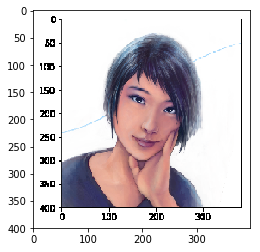

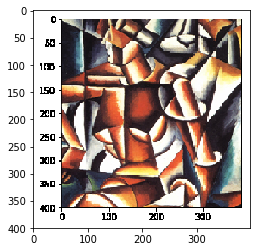

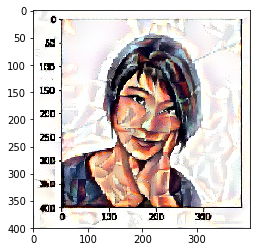

In [12]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()


Keep in mind that what this technique achieves is merely a form of image re-texturing, or texture transfer. It will work best with style 
reference images that are strongly textured and highly self-similar, and with content targets that don't require high levels of details in 
order to be recognizable. It would typically not be able to achieve fairly abstract feats such as "transferring the style of one portrait to 
another". The algorithm is closer to classical signal processing than to AI, so don't expect it to work like magic!

Additionally, do note that running this style transfer algorithm is quite slow. However, the transformation operated by our setup is simple 
enough that it can be learned by a small, fast feedforward convnet as well -- as long as you have appropriate training data available. Fast 
style transfer can thus be achieved by first spending a lot of compute cycles to generate input-output training examples for a fixed style 
reference image, using the above method, and then training a simple convnet to learn this style-specific transformation. Once that is done, 
stylizing a given image is instantaneous: it's a just a forward pass of this small convnet.


## Take aways

* Style transfer consists in creating a new image that preserves the "contents" of a target image while also capturing the "style" of a 
reference image.
* "Content" can be captured by the high-level activations of a convnet.
* "Style" can be captured by the internal correlations of the activations of different layers of a convnet.
* Hence deep learning allows style transfer to be formulated as an optimization process using a loss defined with a pre-trained convnet.
* Starting from this basic idea, many variants and refinements are possible!

请记住，这种技术所实现的仅仅是一种形式的改变图像纹理，或者叫纹理迁移。如果风格参考图像具有明显的纹理结构且高度自相似，并且内容目标不需要高层次细节就能够被识别，那么这种方法的效果最好。它通常无法实现比较抽象的迁移，比如将一幅肖像的风格迁移到另一幅中。这种算法更接近于经典的信号处理，而不是更接近于人工智能，因此不要指望它能实现魔法般的效果。

此外还请注意，这个风格迁移算法的运行速度很慢。但这种方法实现的变换足够简单，只要有适量的训练数据，一个小型的快速前馈卷积神经网络就可以学会这种变换。因此，实现快速风格迁移的方法是，首先利用这里介绍的方法，花费大量的计算时间对一张固定的风格参考图像生成许多输入- 输出训练样例，然后训练一个简单的卷积神经网络来学习这个特定风格的变换。一旦完成之后，对一张图像进行风格迁移是非常快的，只是这个小型卷积神经网络的一次前向传递而已。

## 小结
* 风格迁移是指创建一张新图像，保留目标图像的内容的同时还抓住了参考图像的风格。
* 内容可以被卷积神经网络更靠顶部的层激活所捕捉到。
* 风格可以被卷积神经网络不同层激活的内部相互关系所捕捉到。
* 因此，深度学习可以将风格迁移表述为一个最优化过程，并用到了一个用预训练卷积神经网络所定义的损失。
* 从这个基本想法出发，可以有许多变体和改进。
